<a href="https://colab.research.google.com/github/OJB-Quantum/QC-Hardware-How-To/blob/main/Qiskit_Metal_3_Xmons_in_Colab_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Headless preflight (Qt off) + deps
import os
os.environ["QT_QPA_PLATFORM"] = "offscreen"
os.environ["MPLBACKEND"] = "Agg"

import matplotlib as mpl
try:
    mpl.use("Agg", force=True)
except TypeError:
    mpl.use("Agg")
print("Matplotlib backend:", mpl.get_backend())

# Scientific + GDS toolchain (incl. Descartes)
!pip install "jedi>=0.16"
%pip -q install --upgrade pip wheel setuptools
%pip -q install "numpy>=1.24" "matplotlib>=3.8" \
                "gdstk>=0.9.61" "shapely>=2.0" "ezdxf>=1.2.0" \
                "pandas>=2.0" "scipy>=1.10" "networkx>=2.8" \
                "pint>=0.20" "addict>=2.4.0" "pyyaml>=6.0.1" \
                "qutip>=4.7" "h5py>=3.8" "descartes>=1.1" "jedi>=0.19.1"

Matplotlib backend: Agg


In [ ]:
#@title Clone Metal; bind to /content/qiskit-metal; headless, layout-only init (Dict + is_component)
# pylint: disable=invalid-name
import os, sys, re, textwrap
from pathlib import Path

# Fresh clone
!rm -rf /content/qiskit-metal
!git clone --depth 1 https://github.com/qiskit-community/qiskit-metal /content/qiskit-metal

root = Path("/content/qiskit-metal")
pkg  = root / "qiskit_metal"
assert pkg.exists(), f"Package folder missing: {pkg}"

# Force Python to import FROM THIS FOLDER (no editable install)
if str(root) not in sys.path:
    sys.path.insert(0, str(root))
os.environ["PYTHONPATH"] = str(root) + (":" + os.environ.get("PYTHONPATH",""))

# --- Replace qiskit_metal/__init__.py with a minimal but compatible headless init ---
orig_init = (pkg / "__init__.py").read_text(encoding="utf-8")
(pkg / "__init__orig.py").write_text(orig_init, encoding="utf-8")

minimal_init = textwrap.dedent("""
    # [colab] Headless, layout-only __init__ (no GUI, no analyses), keep essentials.
    import logging as _logging
    try:
        from addict import Dict as Dict
    except Exception:
        from .toolbox_python.attr_dict import Dict

    logger = _logging.getLogger("qiskit_metal_colab")

    class _Config:
        @staticmethod
        def is_building_docs():
            return False
    config = _Config()

    def is_design(obj):
        try:
            from .designs.design_base import QDesign
            return isinstance(obj, QDesign)
        except Exception:
            return False

    def is_component(obj):
        try:
            from .qlibrary.core.base import QComponent
            return isinstance(obj, QComponent)
        except Exception:
            return False

    __all__ = ["Dict", "config", "logger", "is_design", "is_component"]
""").strip()+"\n"
(pkg / "__init__.py").write_text(minimal_init, encoding="utf-8")

# --- Scrub ALL draw.mpl imports to avoid PySide2 at import time ---
draw_init = pkg / "draw" / "__init__.py"
if draw_init.exists():
    d = draw_init.read_text(encoding="utf-8")
    # Guard "from . import mpl"
    d = re.sub(r'^\s*from\s+\.\s*import\s+mpl\s*$',
               "try:\n    from . import mpl\n"
               "except Exception as _e:\n"
               "    print('[colab] draw.mpl disabled (headless):', _e)\n",
               d, flags=re.MULTILINE)
    # Guard "from .mpl import ..." and any other .mpl imports
    d = re.sub(r'^\s*from\s+\.\s*mpl\s+import[^\n]*$',
               "try:\n    from .mpl import render, figure_spawn\n"
               "except Exception as _e:\n"
               "    print('[colab] draw.mpl (named) disabled (headless):', _e)\n"
               "    def render(*a, **k):\n"
               "        raise RuntimeError('draw.mpl unavailable in headless mode')\n"
               "    def figure_spawn(*a, **k):\n"
               "        raise RuntimeError('draw.mpl unavailable in headless mode')\n",
               d, flags=re.MULTILINE)
    draw_init.write_text(d, encoding="utf-8")

# Optional: ensure renderers package never drags Qt; keep explicit imports only
rndr_init = pkg / "renderers" / "__init__.py"
if rndr_init.exists():
    (rndr_init.parent / "__init__orig.py").write_text(rndr_init.read_text(encoding="utf-8"), encoding="utf-8")
    rndr_init.write_text("# [colab] minimal renderers package (explicit imports only; no Qt/MPL)\n__all__ = []\n",
                         encoding="utf-8")

# Verify: import the package *from this folder* and keep it light
import importlib, sys as _sys
importlib.invalidate_caches()
import qiskit_metal
print("qiskit_metal from:", qiskit_metal.__file__)
assert qiskit_metal.__file__.startswith(str(pkg)), "Not importing from /content/qiskit-metal!"

Cloning into '/content/qiskit-metal'...
remote: Enumerating objects: 1050, done.
remote: Counting objects: 100% (1050/1050), done.
remote: Compressing objects: 100% (952/952), done.
remote: Total 1050 (delta 166), reused 673 (delta 88), pack-reused 0 (from 0)
Receiving objects: 100% (1050/1050), 30.22 MiB | 28.10 MiB/s, done.
Resolving deltas: 100% (166/166), done.
qiskit_metal from: /content/qiskit-metal/qiskit_metal/__init__.py


In [ ]:
#@title Setup: clone-based import, strict no-gdspy/no-pyepr, correct qlibrary paths
"""
Headless geometry-only workflow for a 3× X-mon array with 2-JJ SQUID loops.
- Uses Qiskit Metal ONLY to generate geometry (no EPR, no solvers).
- Exports directly with GDSTK (no gdspy, no pyepr).
"""

import os, sys, glob, subprocess
os.environ.setdefault("QT_QPA_PLATFORM", "offscreen")  # headless

# Ensure your Qiskit Metal clone is importable without pip-installing.
try:
    import qiskit_metal  # noqa: F401
except ModuleNotFoundError:
    candidates = [p for p in glob.glob("/content/**/qiskit_metal", recursive=True) if os.path.isdir(p)]
    if not candidates:
        raise ModuleNotFoundError(
            "qiskit_metal clone not found under /content. "
            "Mount or place the clone so /content/**/qiskit_metal exists."
        )
    sys.path.insert(0, os.path.dirname(candidates[0]))
    import qiskit_metal  # noqa: F401

# Ensure GDSTK (not gdspy)
try:
    import gdstk  # noqa: F401
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "gdstk>=0.9.5"])
    import gdstk  # noqa: F401

# Scientific stack
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Optional

# Qiskit Metal (geometry-only) imports — canonical module paths:
from qiskit_metal import Dict as QmDict
from qiskit_metal.designs import DesignPlanar
from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross          # docs example import
from qiskit_metal.qlibrary.qubits.SQUID_loop import SQUID_LOOP                 # 2-JJ loop component
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround     # terminations
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight           # simple routing

# Sanity: do not allow gdspy/pyepr to sneak in.
assert "gdspy" not in sys.modules, "gdspy was imported; this workflow must use gdstk only."
assert "pyepr" not in sys.modules, "pyepr was imported; this workflow must avoid EPR tooling."

plt.rcParams["figure.dpi"] = 120
print("Imports OK. Using Qiskit Metal as a geometry factory and GDSTK for GDS export.")


Imports OK. Using Qiskit Metal as a geometry factory and GDSTK for GDS export.


In [ ]:
#@title Imports from your clone (no gdspy, no pyEPR), headless-safe
"""
Geometry-only workflow:
- Import Qiskit-Metal directly from your existing clone.
- Disable all auto-renderers to prevent pyEPR/HFSS imports.
- Use GDSTK for GDS export (no gdspy, no QGDSRenderer).
"""
import os, sys, glob, subprocess
os.environ.setdefault("QT_QPA_PLATFORM", "offscreen")  # headless-friendly

# ----- Ensure your clone is on sys.path without pip-install -----
try:
    import qiskit_metal  # noqa: F401
except ModuleNotFoundError:
    candidates = [p for p in glob.glob("/content/**/qiskit_metal", recursive=True) if os.path.isdir(p)]
    if not candidates:
        raise ModuleNotFoundError(
            "qiskit_metal clone not found under /content. "
            "Mount/place the clone so /content/**/qiskit_metal exists."
        )
    sys.path.insert(0, os.path.dirname(candidates[0]))
    import qiskit_metal  # noqa: F401

# ----- Strictly require GDSTK (not gdspy) -----
try:
    import gdstk  # noqa: F401
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "gdstk>=0.9.5"])
    import gdstk  # noqa: F401

# ----- Scientific stack -----
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple

# ----- Qiskit Metal imports (geometry library only) -----
from qiskit_metal import Dict as QmDict
from qiskit_metal.designs import DesignPlanar
from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross
from qiskit_metal.qlibrary.qubits.SQUID_loop import SQUID_LOOP
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround  # optional
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight

# ----- Eradicate auto-renderers up front (prevents pyEPR import) -----
from qiskit_metal import config as _metal_cfg
try:
    _metal_cfg.renderers_to_load.clear()  # keep renderer registry empty
except Exception:
    pass  # robust to API variation

# Sanity: neither gdspy nor pyEPR should be imported anywhere.
assert "gdspy" not in sys.modules, "gdspy was imported; this pipeline must use gdstk only."
assert "pyEPR" not in sys.modules, "pyEPR was imported; this is a geometry-only pipeline."

plt.rcParams["figure.dpi"] = 120
print("Imports OK • Using Qiskit-Metal clone + GDSTK • Renderers disabled (no pyEPR).")


Imports OK • Using Qiskit-Metal clone + GDSTK • Renderers disabled (no pyEPR).


In [ ]:
#@title Imports from your clone (strict: no gdspy, no pyEPR)
"""
Geometry-only flow:
- Import Qiskit Metal directly from your clone.
- Disable all auto-renderers so pyEPR/HFSS are never imported.
- Use GDSTK exclusively for GDS export (no gdspy).
"""
import os, sys, glob, subprocess
os.environ.setdefault("QT_QPA_PLATFORM", "offscreen")  # headless-safe

# --- Make sure your qiskit_metal clone is importable without pip-install ---
try:
    import qiskit_metal  # noqa: F401
except ModuleNotFoundError:
    candidates = [p for p in glob.glob("/content/**/qiskit_metal", recursive=True) if os.path.isdir(p)]
    if not candidates:
        raise ModuleNotFoundError(
            "qiskit_metal clone not found under /content. "
            "Mount/place the clone so /content/**/qiskit_metal exists."
        )
    sys.path.insert(0, os.path.dirname(candidates[0]))
    import qiskit_metal  # noqa: F401

# --- Require GDSTK (not gdspy) ---
try:
    import gdstk  # noqa: F401
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "gdstk>=0.9.5"])
    import gdstk  # noqa: F401

# --- Scientific stack ---
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple

# --- Qiskit Metal (geometry library only) ---
from qiskit_metal import Dict as QmDict
from qiskit_metal.designs import DesignPlanar

# Transmon cross
try:
    from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross
except Exception:
    # Some clones use capitalized file names
    from qiskit_metal.qlibrary.qubits.TransmonCross import TransmonCross  # type: ignore

# Manhattan JJ (try common paths)
_jj_exc = None
try:
    from qiskit_metal.qlibrary.qubits.JJ_Manhattan import jj_manhattan
except Exception as _e1:
    _jj_exc = _e1
    try:
        from qiskit_metal.qlibrary.qubits.jj_manhattan import jj_manhattan  # fallback
    except Exception as _e2:
        _jj_exc = _e2
        try:
            # Some repos place it under components/junction
            from qiskit_metal.qlibrary.components.junction.jj_manhattan import jj_manhattan
        except Exception as _e3:
            raise ImportError(
                f"Could not import jj_manhattan from your clone. Last error: {_e3}\n"
                "Please locate the Manhattan JJ component in your qiskit_metal clone and adjust the import."
            )

# Handy termination for reference pins (optional)
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight

# --- Eradicate auto-renderers so pyEPR is never imported ---
from qiskit_metal import config as _metal_cfg
try:
    _metal_cfg.renderers_to_load.clear()
except Exception:
    pass

# --- Hard sanity: neither gdspy nor pyEPR should be around ---
assert "gdspy" not in sys.modules, "gdspy was imported; this pipeline must use gdstk only."
assert "pyEPR" not in sys.modules, "pyEPR was imported; this is a geometry-only pipeline."

plt.rcParams["figure.dpi"] = 120
print("Imports OK • Qiskit-Metal clone + GDSTK • Renderers disabled (no pyEPR).")


Imports OK • Qiskit-Metal clone + GDSTK • Renderers disabled (no pyEPR).


In [ ]:
#@title Control knobs (edit as needed)
# ---------- Chip canvas ----------
CHIP_W_MM, CHIP_H_MM = 10.0, 10.0

# ---------- Layers ----------
LAYER_METAL = 1            # positive metal
LAYER_JJ    = 15           # e-beam JJ layer (separate from metal)
LAYER_NEG   = 10           # optional subtract/etch layer during export
INVERT_POLARITY = False    # leave as positive-mask flow unless you invert downstream

# ---------- X-mon capacitor ----------
CROSS_WIDTH_UM   = 20.0
CROSS_LENGTH_UM  = 200.0
CROSS_GAP_UM     = 16.0
ORIENTATION_DEG  = 0.0        # 0° => "south" arm points to -y

# Per-qubit small variation (decorrelate EC/f01 geometrically; no analysis here)
CROSS_LENGTH_SCALE = [0.94, 1.00, 1.06]

# ---------- Manhattan JJ placement ----------
JJ_LAYER               = LAYER_JJ
# Shift JJs 35 microns left (-35) and 28 microns down (-28)
JJ_POS_TWEAK_UM        = (-35.0, -18.0)     # fine (dx, dy) tweak in µm if your PDK needs it
JJ_ORIENT_OFFSET_DEG   = 90.0           # rotate JJ so its finger axis aligns with local south (+/-90°)
# You can also override JJ size parameters by giving additional jj_manhattan options below, if desired.

# ---------- Array placement ----------
N_QUBITS    = 3
ROW_Y_MM    = 0.0
START_X_MM  = -3.0
PITCH_X_MM  = 3.2

# ---------- Optional stubs to local grounds (one terminator per stub) ----------
MAKE_LOCAL_GNDS = True
ROUTE_WIDTH_UM  = 6.0
ROUTE_FILLET_UM = 0.0          # straight 2-point path → keep fillet 0 to avoid warnings

# ---------- Export ----------
GDS_OUT = "/content/xmon_3q_with_real_jjs_gdstk.gds"

In [ ]:
#@title Helpers: units, JJ pose/placement, Matplotlib preview
import pandas as pd

def um(v: float) -> str:
    """Return a micrometer string for Qiskit-Metal, e.g., '25um'."""
    return f"{v:.6g}um"

def mm(v: float) -> str:
    """Return a millimeter string for Qiskit-Metal, e.g., '3.2mm'."""
    return f"{v:.6g}mm"

def make_geometry_only_design() -> DesignPlanar:
    """Factory: DesignPlanar with renderers disabled and overwrite enabled."""
    return DesignPlanar(enable_renderers=False, overwrite_enabled=True)

def xmon_south_gap_pose(design: DesignPlanar, q: TransmonCross) -> Tuple[float, float, float]:
    """Return (x_mm, y_mm, orient_deg) for a JJ centered in the X-mon south gap."""
    L = float(design.parse_value(q.options.cross_length))  # mm
    g = float(design.parse_value(q.options.cross_gap))     # mm
    x0 = float(design.parse_value(q.options.pos_x))
    y0 = float(design.parse_value(q.options.pos_y))
    theta = float(q.options.orientation) if "orientation" in q.options else 0.0  # deg

    # Center of the south arm gap at y = -(L + g/2) in local coords
    local = np.array([0.0, -(L + 0.5 * g)], dtype=float)

    # Rotate by theta (deg) and translate to (x0, y0)
    t = np.deg2rad(theta)
    R = np.array([[np.cos(t), -np.sin(t)],
                  [np.sin(t),  np.cos(t)]], dtype=float)
    px, py = (np.array([x0, y0]) + R @ local)

    # Fine-tune in µm -> mm
    px += JJ_POS_TWEAK_UM[0] / 1000.0
    py += JJ_POS_TWEAK_UM[1] / 1000.0

    # Orient JJ along the local south axis: rotate Manhattan JJ by theta + offset
    phi = theta + JJ_ORIENT_OFFSET_DEG
    return px, py, phi

def add_manhattan_jj_at_south(design: DesignPlanar, q: TransmonCross, name: str) -> object:
    """Create a Manhattan JJ at the south gap of a given X-mon."""
    x_mm, y_mm, phi_deg = xmon_south_gap_pose(design, q)
    jj_opts = dict(
        pos_x=mm(x_mm),
        pos_y=mm(y_mm),
        orientation=str(phi_deg),
        layer=JJ_LAYER,
        chip="main",
    )
    # If you want to enforce specific pad/finger sizes, add them here, e.g.:
    # jj_opts.update(dict(pad_width='1.5um', pad_height='1.0um', finger_width='0.2um', gap='0.15um'))
    jj = jj_manhattan(design, name=name, options=jj_opts)
    return jj

def _plot_qgeometry_outline(design: DesignPlanar, ax, linewidth=0.35, show_holes=True):
    """Plot outlines from qgeometry poly/path tables (mm)."""
    polys = design.qgeometry.tables.get("poly")
    if isinstance(polys, pd.DataFrame) and len(polys):
        for _, row in polys.iterrows():
            g = row.geometry
            if g is None:
                continue
            geoms = getattr(g, "geoms", [g])
            for pg in geoms:
                if not hasattr(pg, "exterior"):
                    continue
                x, y = pg.exterior.coords.xy
                ax.plot(x, y, linewidth=linewidth)
                if show_holes:
                    for hole in getattr(pg, "interiors", []):
                        hx, hy = hole.coords.xy
                        ax.plot(hx, hy, linewidth=max(0.1, 0.5 * linewidth))

    paths = design.qgeometry.tables.get("path")
    if isinstance(paths, pd.DataFrame) and len(paths):
        for _, row in paths.iterrows():
            g = row.geometry
            if g is None:
                continue
            geoms = getattr(g, "geoms", [g])
            for ln in geoms:
                x, y = ln.coords.xy
                ax.plot(x, y, linewidth=linewidth)

def preview_design_matplotlib(design: DesignPlanar,
                              dpi_onscreen: int = 300,
                              figsize: Tuple[float, float] = (9, 7),
                              linewidth: float = 0.35,
                              show_holes: bool = True):
    """Onscreen Matplotlib preview; keep dpi modest for Colab responsiveness."""
    import matplotlib.pyplot as plt
    import pandas as pd

    tables = design.qgeometry.tables
    poly_df = tables.get("poly")
    path_df = tables.get("path")
    n_poly = (0 if not isinstance(poly_df, pd.DataFrame) else len(poly_df))
    n_path = (0 if not isinstance(path_df, pd.DataFrame) else len(path_df))
    print(f"[diag] qgeometry counts — poly={n_poly}, path={n_path}")

    plt.close("all")
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi_onscreen)
    _plot_qgeometry_outline(design, ax, linewidth=linewidth, show_holes=show_holes)
    ax.set_aspect("equal", "box")
    ax.set_xlabel("x (mm)")
    ax.set_ylabel("y (mm)")
    ax.set_title("3× X-mon with real Manhattan JJs")
    fig.tight_layout()
    plt.show()

Components: ['JJ0', 'JJ1', 'JJ2', 'Q0', 'Q1', 'Q2']
[diag] qgeometry counts — poly=9, path=0


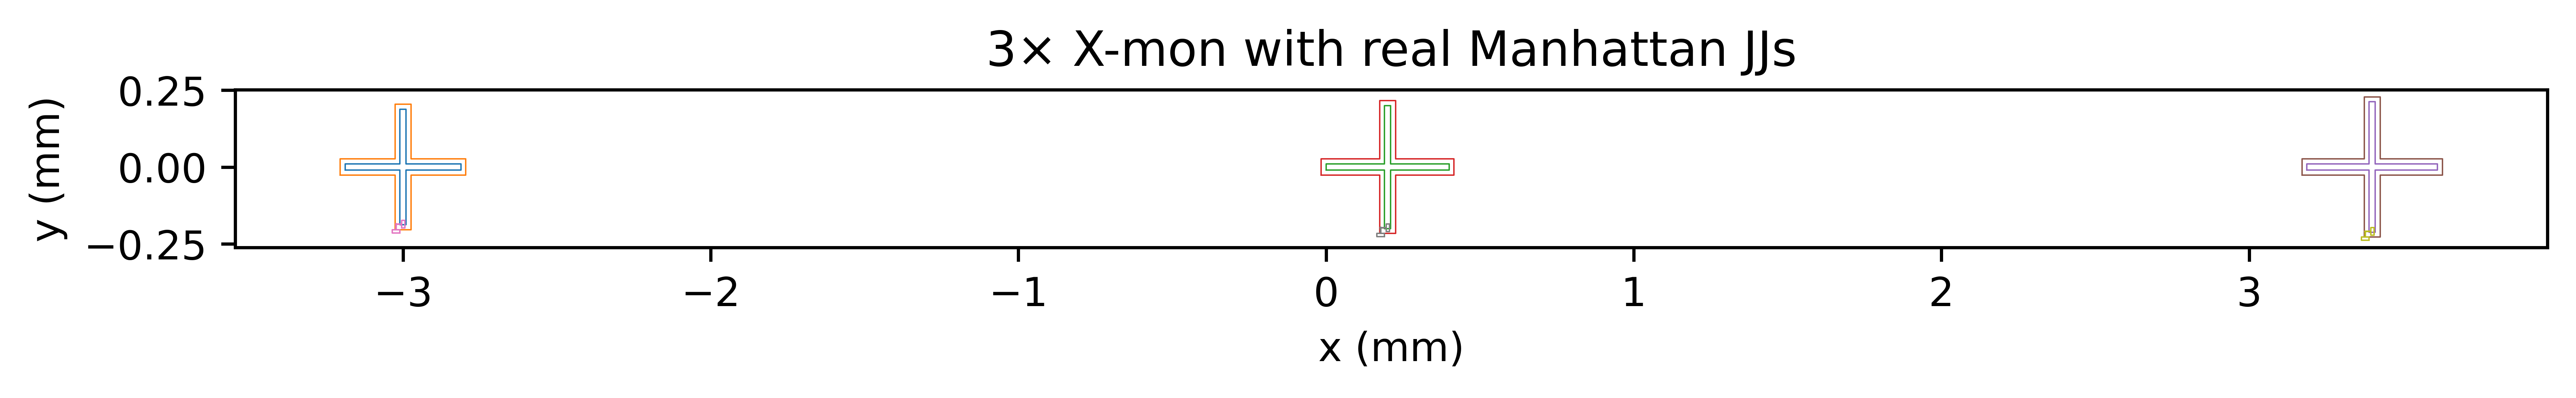

In [ ]:
#@title Build geometry: 3 X-mons + real Manhattan JJs (no renderers, no stubs)
design = make_geometry_only_design()

# Canvas extents
chip = design.chips["main"]
chip.size["size_x"] = mm(CHIP_W_MM)
chip.size["size_y"] = mm(CHIP_H_MM)

# Three X-mon qubits
xmons: List[TransmonCross] = []
for i in range(N_QUBITS):
    pos_x = START_X_MM + i * PITCH_X_MM
    scale = CROSS_LENGTH_SCALE[i]
    q = TransmonCross(
        design,
        name=f"Q{i}",
        options=dict(
            pos_x=mm(pos_x),
            pos_y=mm(ROW_Y_MM),
            orientation=str(ORIENTATION_DEG),
            cross_width=um(CROSS_WIDTH_UM),
            cross_gap=um(CROSS_GAP_UM),
            cross_length=um(CROSS_LENGTH_UM * scale),
            layer=LAYER_METAL,
        ),
    )
    xmons.append(q)

# Real Manhattan JJs at each X-mon south gap (on JJ_LAYER)
jjs = []
for i, q in enumerate(xmons):
    jj = add_manhattan_jj_at_south(design, q, name=f"JJ{i}")
    jjs.append(jj)

design.rebuild()

print("Components:", sorted(list(design.components.keys())))
preview_design_matplotlib(design, dpi_onscreen=800)

In [ ]:
#@title Export to GDS with GDSTK (polys + paths; holes via boolean)
import pandas as pd

def _coords_as_array(pg):
    """Return (outer, holes) arrays from a Shapely Polygon."""
    ox, oy = pg.exterior.coords.xy
    outer = np.column_stack([np.asarray(ox), np.asarray(oy)])
    holes = []
    for interior in getattr(pg, "interiors", []):
        hx, hy = interior.coords.xy
        holes.append(np.column_stack([np.asarray(hx), np.asarray(hy)]))
    return outer, holes

def _to_mm(val, design):
    """Parse a numeric-or-string width to mm using design.parse_value when needed."""
    if isinstance(val, str):
        return float(design.parse_value(val))  # returns mm
    if val is None or (isinstance(val, float) and np.isnan(val)):
        return 0.0
    return float(val)

def export_design_to_gdstk(
    design: DesignPlanar,
    out_path: str,
    unit_m: float = 1e-6,
    layer_for_neg: Optional[int] = None,
    assume_mm: bool = True,
    boolean_precision: float = 1e-3,     # 1e-3 user-units ≈ 1 nm when unit_m=1e-6
    paths_as_polygons: bool = False      # set True if your mask flow forbids PATHs
) -> None:
    """
    Convert qgeometry (poly + path) to a single-cell GDS using GDSTK.

    * GDS doesn't support polygon holes directly; we emit them via boolean:
      result = boolean(outer, union(holes), "not").
    * With unit_m=1e-6, the user unit is µm; if qgeometry is in mm, scale=1000.
    """
    lib = gdstk.Library(unit=unit_m, precision=1e-9)
    top = gdstk.Cell("TOP")
    lib.add(top)

    scale = 1000.0 if assume_mm and math.isclose(unit_m, 1e-6) else 1.0

    # -------- POLYGONS --------
    polys = design.qgeometry.tables.get("poly")
    if isinstance(polys, pd.DataFrame) and len(polys):
        for _, row in polys.iterrows():
            geom = row.geometry
            if geom is None:
                continue

            lyr = int(row.get("layer", LAYER_METAL))
            subtract = bool(row.get("subtract", False))
            dest_layer = (layer_for_neg if (subtract and layer_for_neg is not None) else lyr)

            geoms = getattr(geom, "geoms", [geom])
            for pg in geoms:
                if not hasattr(pg, "exterior"):
                    continue
                outer, holes = _coords_as_array(pg)
                outer *= scale
                holes = [h * scale for h in holes] if holes else []

                if holes:
                    result = gdstk.boolean([outer], holes, "not",
                                           precision=boolean_precision,
                                           layer=dest_layer, datatype=0)
                    for poly in result:
                        top.add(poly)
                else:
                    top.add(gdstk.Polygon(outer, layer=dest_layer, datatype=0))

    # -------- PATHS --------
    paths = design.qgeometry.tables.get("path")
    if isinstance(paths, pd.DataFrame) and len(paths):
        for _, row in paths.iterrows():
            geom = row.geometry
            if geom is None:
                continue

            lyr = int(row.get("layer", LAYER_METAL))
            width_mm = _to_mm(row.get("width", 0.01), design)  # default 0.01 mm = 10 µm
            width_user = width_mm * (1000.0 if assume_mm else 1.0)

            geoms = getattr(geom, "geoms", [geom])
            for ln in geoms:
                x, y = ln.coords.xy
                pts = np.column_stack([np.asarray(x), np.asarray(y)]) * scale
                fp = gdstk.FlexPath(pts, width_user, layer=lyr, datatype=0)
                if paths_as_polygons:
                    for poly in fp.to_polygons():
                        poly.layer = lyr
                        top.add(poly)
                else:
                    top.add(fp)

    lib.write_gds(out_path)
    print(f"[GDSTK] Wrote: {out_path}")

# ---- Run the exporter ----
export_design_to_gdstk(
    design,
    GDS_OUT,
    unit_m=1e-6,  # user unit = µm
    layer_for_neg=(LAYER_NEG if not INVERT_POLARITY else None),
    assume_mm=True,
    boolean_precision=1e-3,
    paths_as_polygons=False
)

[GDSTK] Wrote: /content/xmon_3q_with_real_jjs_gdstk.gds
